In [1]:
import pandas as pd
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
np.random.seed(42)
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet, ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

Using plaidml.keras.backend backend.


In [2]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

/Users/gmarchetti/anaconda3/envs/plaidml/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
INFO:plaidml:Opening device "metal_amd_radeon_pro_455.0"


In [3]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [4]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [5]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)
test_generator=test_datagen.flow_from_directory('./test/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 182 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
history=model.fit_generator(generator=train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=step_size_train,
                            epochs=5)

Epoch 1/5


INFO:plaidml:Analyzing Ops: 825 of 2653 operations complete


1/5 [=====>........................] - ETA: 49s - loss: 1.4807 - acc: 0.0909

INFO:plaidml:Analyzing Ops: 891 of 2653 operations complete


5/5 [==============================] - 31s 6s/step - loss: 2.1491 - acc: 0.4534 - val_loss: 1.6484 - val_acc: 0.4000
Epoch 2/5
5/5 [==============================] - 8s 2s/step - loss: 0.3364 - acc: 0.9000 - val_loss: 0.2336 - val_acc: 0.8667
Epoch 3/5
5/5 [==============================] - 8s 2s/step - loss: 0.0857 - acc: 0.9874 - val_loss: 0.3741 - val_acc: 0.8667
Epoch 4/5
5/5 [==============================] - 8s 2s/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.7983 - val_acc: 0.9333
Epoch 5/5
5/5 [==============================] - 8s 2s/step - loss: 0.0828 - acc: 0.9937 - val_loss: 1.3414 - val_acc: 0.9333


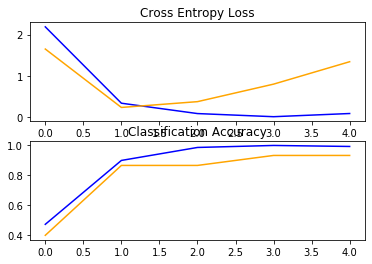

In [7]:
# plot loss
plt.subplot(2,1,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.title('Cross Entropy Loss')
# plot accuracy
plt.subplot(2,1,2)
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')
plt.title('Classification Accuracy')
# save plot to file
filename = 'mobilenet'
plt.savefig(filename + '_plot.png')
plt.show()
plt.close()



In [8]:
# now try with ResNet

In [9]:
base_model=ResNet50(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
for layer in base_model.layers:
            layer.trainable = False
x=base_model.output
x=Dense(128,activation='relu')(x) #dense layer 1
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

/Users/gmarchetti/anaconda3/envs/plaidml/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [10]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
step_size_train=train_generator.n//train_generator.batch_size
history=model.fit_generator(generator=train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=step_size_train,
                            epochs=5)

Epoch 1/5
5/5 [==============================] - 9s 2s/step - loss: 0.6662 - acc: 0.9431 - val_loss: 2.3129 - val_acc: 0.8667
Epoch 2/5
5/5 [==============================] - 8s 2s/step - loss: 0.1545 - acc: 0.9613 - val_loss: 8.2160 - val_acc: 0.5333
Epoch 3/5
5/5 [==============================] - 8s 2s/step - loss: 0.1889 - acc: 0.9375 - val_loss: 0.8928 - val_acc: 0.9333
Epoch 4/5
5/5 [==============================] - 8s 2s/step - loss: 0.1971 - acc: 0.9471 - val_loss: 0.5951 - val_acc: 0.9333
Epoch 5/5
5/5 [==============================] - 8s 2s/step - loss: 0.0481 - acc: 0.9874 - val_loss: 0.6354 - val_acc: 0.9333


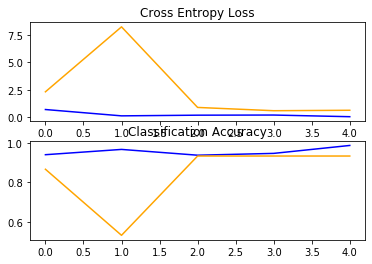

In [11]:
# plot loss
plt.subplot(2,1,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.title('Cross Entropy Loss')
# plot accuracy
plt.subplot(2,1,2)
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')
plt.title('Classification Accuracy')
# save plot to file
filename = 'resnet50'
plt.savefig(filename + '_plot.png')
plt.show()
plt.close()